This project utilizes the PokeAPI (https://pokeapi.co/) to create a large database containing relvent information on Pokemon to be used for future projects. Note: This is not complete - Work In Progress

### Import the required Libraries

In [33]:
import requests
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

### Create The Inital pd dataframes

In [2]:
pokedf =  pd.DataFrame(columns = ['name','species', 'height', 'weight', 'abilities', 'types', 'stats'])
specdf = pd.DataFrame(columns = ['name','pokedex','gen','genus', 'capture_rate', 'color', 'shape', 'egg_groups', 'is_baby', 'is_legendary', 'is_mythical'])

### Functions to request Data

Data Sourced From PokeAPI

In [3]:
def get_pokemon_info(url):
    response = requests.get(url)
    
    if response.status_code == 200:
        pokemon_data = response.json()
        pokemon_info = {
            "name": pokemon_data["name"],
            "species": pokemon_data["species"]["name"],
            "height": pokemon_data["height"],
            "weight": pokemon_data["weight"],
            "abilities": [ability["ability"]["name"] for ability in pokemon_data["abilities"]],
            "types": [stats_data["type"]["name"] for stats_data in pokemon_data["types"]],
            "stats": [stats_data["base_stat"] for stats_data in pokemon_data["stats"]],
            #"hp": pokemon_data["stats"][0]["base_stat"],
            #"attack": pokemon_data["stats"][1]["base_stat"],
            #"defence": pokemon_data["stats"][2]["base_stat"],
            #"sp_attack": pokemon_data["stats"][3]["base_stat"],
            #"sp_defence": pokemon_data["stats"][4]["base_stat"],
            #"speed": pokemon_data["stats"][5]["base_stat"],
        }
        pokedf.loc[len(pokedf)] = pokemon_info
        return None
    else:
        return None

In [4]:
def get_species_info(url):
    response = requests.get(url)
    
    if response.status_code == 200:
        species_data = response.json()
        species_info = {
            "name": species_data["name"],
            "pokedex": species_data["pokedex_numbers"][0]["entry_number"],
            "gen": species_data["generation"]["name"],
            #"genus": species_data["genera"]["genus"],
            "capture_rate": species_data["capture_rate"],
            "color": species_data["color"]["name"],
            #"shape": species_data["shape"]["name"],
            "egg_groups": [group["name"] for group in species_data["egg_groups"]],
            "is_baby": species_data["is_baby"],
            "is_legendary": species_data["is_legendary"],
            "is_mythical": species_data["is_mythical"],            
        }
        specdf.loc[len(specdf)] = species_info
        return None
    else:
        return None

### WebScraping to Create the DataFrames

In [5]:
t0 = time.time()
# Pokemon df
url = f"https://pokeapi.co/api/v2/pokemon?limit=100000&offset=0"    #Real URL
#url = f"https://pokeapi.co/api/v2/pokemon?limit=50&offset=0"        #test URL
response = requests.get(url)
poke = response.json()
for pokemon in poke['results']:
    get_pokemon_info(pokemon['url'])
    
t1 = time.time()
timer = t1-t0
print(f"time elapsed: {timer/60} minutes")

time elapsed: 19.538207312424976 minutes


In [6]:
t0 = time.time()
#Species df
url = f"https://pokeapi.co/api/v2/pokemon-species?limit=100000&offset=0"   #Real URL
#url = f"https://pokeapi.co/api/v2/pokemon-species?limit=50&offset=0"    #test URL
response = requests.get(url)
species = response.json()
for spec in species['results']:
    get_species_info(spec['url'])

t1 = time.time()
timer = t1-t0
print(f"time elapsed: {timer/60} minutes")

time elapsed: 12.33495876789093 minutes


In [7]:
#Backup df
pokedf_backup = pokedf.copy()
specdf_backup = specdf.copy()

### Function to edit generation format (Data Cleaning)

In [8]:
def get_generation(generation):
    if generation == 'generation-i':
        return 1
    elif generation == 'generation-ii':
        return 2
    elif generation == 'generation-iii':
        return 3
    elif generation == 'generation-iv':
        return 4
    elif generation == 'generation-v':
        return 5
    elif generation == 'generation-vi':
        return 6
    elif generation == 'generation-vii':
        return 7
    elif generation == 'generation-viii':
        return 8
    elif generation == 'generation-ix':
        return 9
    else:
        return "NA"

# Manipulating Dataframes  

In [9]:
#Spread out Types/Abilities/Stats
pokedf[['hp', 'attack', 'defence', 'sp_attack', 'sp_defence', 'speed']] = pd.DataFrame(pokedf.stats.tolist(), index= pokedf.index)
pokedf[['type1','type2']] = pd.DataFrame(pokedf.types.tolist(), index= pokedf.index)
pokedf[['ability1','ability2', 'hidden_ability']] = pd.DataFrame(pokedf.abilities.tolist(), index= pokedf.index)

#Pop Original Columns
stats_col = pokedf.pop('stats')
types_col = pokedf.pop('types')
abilities_col = pokedf.pop('abilities')

In [10]:
#Format Generation
specdf["generation"] = specdf["gen"].apply(get_generation)
del specdf['gen']

#Spread out egg groups
specdf[['egg_group1','egg_group2']] = pd.DataFrame(specdf.egg_groups.tolist(), index= specdf.index)
egg_groups_col = specdf.pop('egg_groups')

In [11]:
#Merge the dataframes
df2 = pd.merge(pokedf, specdf, how="left", left_on='species', right_on='name')
del df2['name_y']
df2 = df2.rename(columns={'name_x': 'name'})

In [12]:
df2['is_mega'] = pd.DataFrame(df2.name.str.contains("-mega"))
df2.head()

,name,species,height,weight,hp,attack,defence,sp_attack,sp_defence,speed,...,capture_rate,color,shape,is_baby,is_legendary,is_mythical,generation,egg_group1,egg_group2,is_mega
0,bulbasaur,bulbasaur,7,69,45,49,49,65,65,45,...,45,green,NaN,False,False,False,1,monster,plant,False
1,ivysaur,ivysaur,10,130,60,62,63,80,80,60,...,45,green,NaN,False,False,False,1,monster,plant,False
2,venusaur,venusaur,20,1000,80,82,83,100,100,80,...,45,green,NaN,False,False,False,1,monster,plant,False
3,charmander,charmander,6,85,39,52,43,60,50,65,...,45,red,NaN,False,False,False,1,monster,dragon,False
4,charmeleon,charmeleon,11,190,58,64,58,80,65,80,...,45,red,NaN,False,False,False,1,monster,dragon,False


## Export / Import CSV

In [13]:
# Full df to CSV
df2 = df2.sort_values(by=['pokedex', 'name'])
df2.to_csv("pokemon_data.csv", index = False)

In [14]:
#Read Data From CSV
#df2 = pd.read_csv('.\pokemon_data.csv')

### Filtering to original forms

In [15]:
filtered_columns = ['name', 'species', 'generation', 'type1','hp', 'attack', 'defence', 'sp_attack', 'sp_defence', 'speed']

In [16]:
df3 = df2.drop_duplicates(subset=['species'])
df1 = df3[filtered_columns]

In [17]:
df1.head()

,name,species,generation,type1,hp,attack,defence,sp_attack,sp_defence,speed
0,bulbasaur,bulbasaur,1,grass,45,49,49,65,65,45
1,ivysaur,ivysaur,1,grass,60,62,63,80,80,60
2,venusaur,venusaur,1,grass,80,82,83,100,100,80
3,charmander,charmander,1,fire,39,52,43,60,50,65
4,charmeleon,charmeleon,1,fire,58,64,58,80,65,80


## Start of Project Analysis

In [18]:
df1[['generation', 'species']].groupby('generation').count()

,species
generation,
1,151
2,100
3,135
4,107
5,156
6,72
7,88
8,96
9,120


## New Pokemon Added Each Generation

Text(0, 0.5, 'New Pokemon')

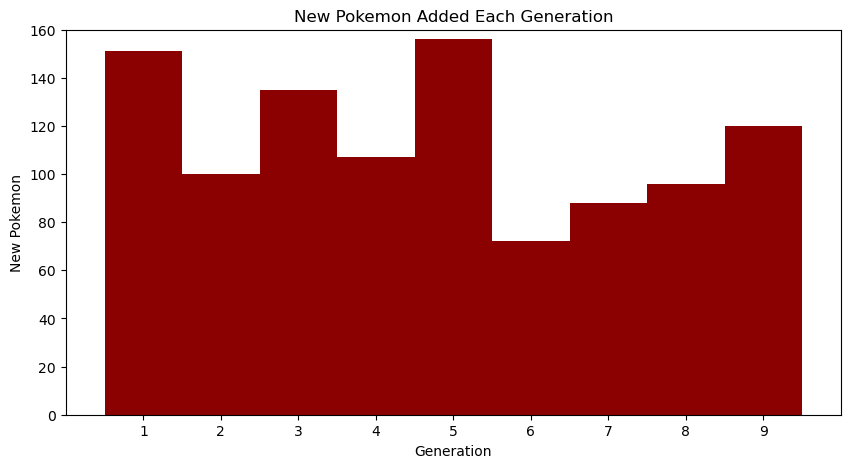

In [19]:
plt.figure(figsize=(10, 5))
values, bins, bars = plt.hist(df1['generation'].values, range(1,11), align = 'left', facecolor='darkred')
plt.axis([0,10,0,160])
plt.xticks([1,2,3,4,5,6,7,8,9])
plt.title('New Pokemon Added Each Generation')
plt.xlabel('Generation')
plt.ylabel('New Pokemon')


In [20]:
#Adding a total Stats bar to the df
df1 = df1.eval('totalstats = hp + attack + defence + sp_attack + sp_defence + speed')

In [21]:
df1.head()

,name,species,generation,type1,hp,attack,defence,sp_attack,sp_defence,speed,totalstats
0,bulbasaur,bulbasaur,1,grass,45,49,49,65,65,45,318
1,ivysaur,ivysaur,1,grass,60,62,63,80,80,60,405
2,venusaur,venusaur,1,grass,80,82,83,100,100,80,525
3,charmander,charmander,1,fire,39,52,43,60,50,65,309
4,charmeleon,charmeleon,1,fire,58,64,58,80,65,80,405


# Stats By Generation

In [22]:
genstats = df1[['generation', 'totalstats']].groupby('generation').mean()
genstats

,totalstats
generation,
1,407.642384
2,407.180000
3,403.725926
4,445.570093
5,425.756410
6,427.722222
7,455.147727
8,439.218750
9,457.391667


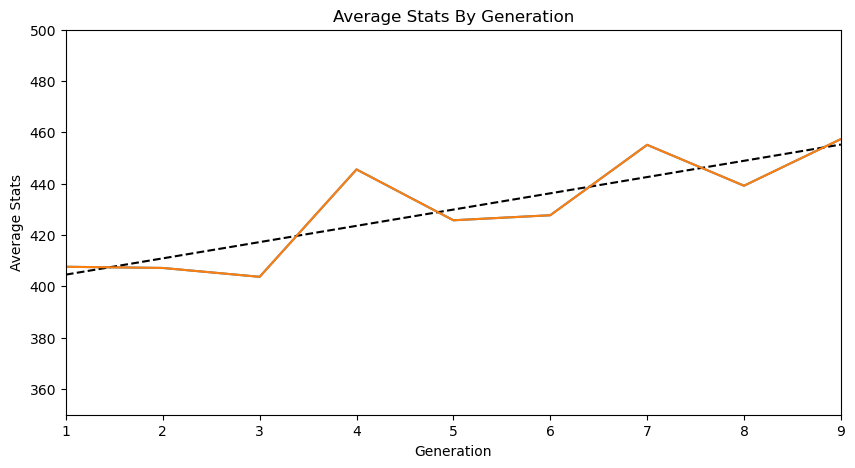

In [23]:
plt.figure(figsize=(10, 5))
x = [1,2,3,4,5,6,7,8,9]
y = genstats['totalstats']

coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef) 
# poly1d_fn is now a function which takes in x and returns an estimate for y

plt.plot(x,y,x, poly1d_fn(x), '--k')
plt.plot(genstats)

# Label the axes
plt.xlabel('Generation')
plt.ylabel('Average Stats')

#label the figure
plt.title('Average Stats By Generation')
plt.axis([1,9,350,500])
# to make more honest, start they y axis at 0







plt.show()

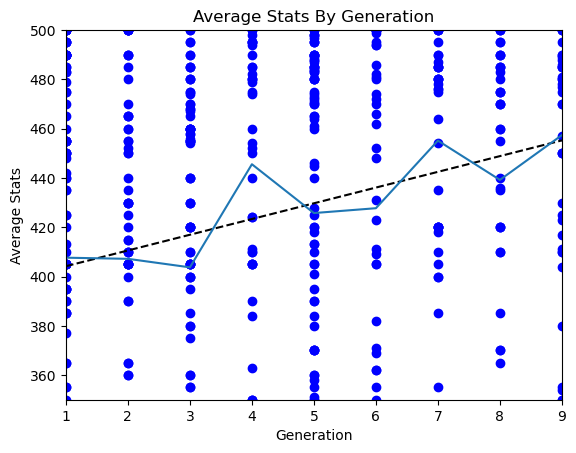

In [24]:

x = df1['generation']
y = df1['totalstats']

coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef) 
# poly1d_fn is now a function which takes in x and returns an estimate for y

plt.plot(x,y, 'bo' , x, poly1d_fn(x), '--k')
plt.plot(genstats)

# Label the axes
plt.xlabel('Generation')
plt.ylabel('Average Stats')

#label the figure
plt.title('Average Stats By Generation')
plt.axis([1,9,350,500])
# to make more honest, start they y axis at 0

plt.show()

# Stats By Type

In [25]:
typestats = df1[['type1', 'totalstats']].groupby('type1').mean()
typestats

,totalstats
type1,
bug,374.638554
dark,454.733333
dragon,487.081081
electric,436.305085
fairy,436.068966
fighting,441.550000
fire,445.676923
flying,436.111111
ghost,431.171429


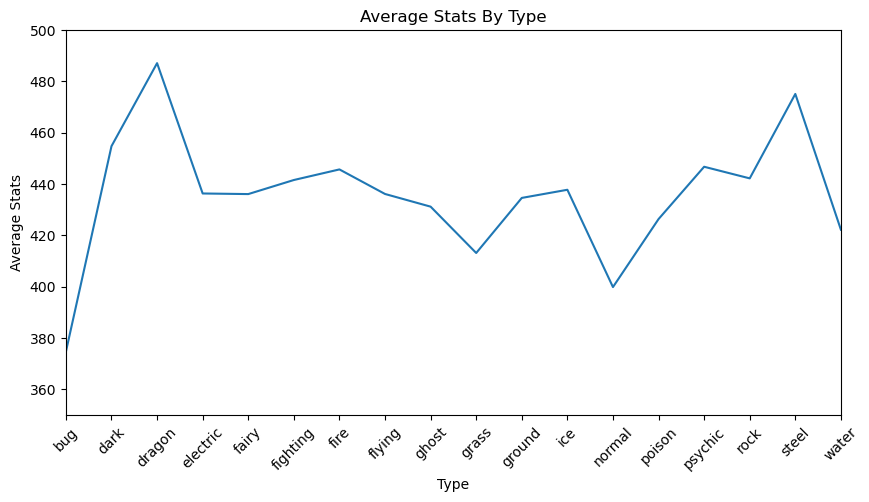

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(typestats)

# Label the axes
plt.xlabel('Type')
plt.ylabel('Average Stats')

#label the figure
plt.title('Average Stats By Type')
plt.xticks(rotation = 45)


plt.axis([0,len(typestats)-1,350,500])
# to make more honest, start they y axis at 0


plt.show()

In [27]:
typess = df1[['type1', 'totalstats']].groupby('type1').count()
typess

,totalstats
type1,
bug,83
dark,45
dragon,37
electric,59
fairy,29
fighting,40
fire,65
flying,9
ghost,35


In [36]:
features = ['hp', 'attack', 'defence', 'sp_attack', 'sp_defence', 'speed']

In [37]:
target = ['generation']

In [38]:
X = df2[features]
y = df2[target]

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=324)

In [40]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [41]:
y_prediction = regressor.predict(X_test)
y_prediction

array([[5.06814274],
       [4.95426199],
       [4.82161136],
       [5.72640565],
       [4.04854168],
       [4.2584377 ],
       [5.02985847],
       [5.39195563],
       [4.90745599],
       [4.72402058],
       [4.19258572],
       [4.50284982],
       [4.37911151],
       [4.96337018],
       [4.7378392 ],
       [5.34904248],
       [5.30542704],
       [6.80944446],
       [4.68099947],
       [4.88725565],
       [5.2414864 ],
       [5.02848302],
       [4.76600636],
       [6.01380884],
       [5.16710666],
       [4.9144468 ],
       [4.58164964],
       [4.2407738 ],
       [4.94051336],
       [5.17613369],
       [4.67176419],
       [4.99535029],
       [4.7290153 ],
       [4.68126565],
       [4.6929144 ],
       [5.05008266],
       [4.7688677 ],
       [4.19258572],
       [4.58651461],
       [4.74172717],
       [4.18858902],
       [4.52387106],
       [5.38639525],
       [5.2124946 ],
       [4.69795587],
       [4.84164463],
       [4.42511526],
       [4.080

In [42]:
RMSE = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))

print(RMSE)

2.6831192542194477


In [43]:
y_test.describe()

,generation
count,430.000000
mean,4.630233
std,2.734655
min,1.000000
25%,2.000000
50%,5.000000
75%,7.000000
max,9.000000


In [44]:
regressor = DecisionTreeRegressor(max_depth=20)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=20)

In [49]:
y_prediction = regressor.predict(X_test)
y_prediction

array([3.1       , 5.04761905, 3.        , 7.        , 8.        ,
       6.        , 7.        , 6.        , 9.        , 1.        ,
       1.        , 5.        , 5.        , 5.        , 3.        ,
       3.        , 9.        , 1.        , 3.        , 6.        ,
       3.1       , 1.        , 1.        , 8.        , 7.        ,
       2.        , 8.        , 1.        , 5.04761905, 5.04761905,
       6.        , 5.04761905, 8.        , 5.        , 8.        ,
       4.        , 5.04761905, 1.        , 1.        , 8.        ,
       1.        , 1.        , 9.        , 3.        , 1.        ,
       3.        , 7.        , 1.5       , 6.        , 1.        ,
       5.        , 3.        , 8.        , 6.        , 4.        ,
       3.        , 3.        , 1.        , 1.        , 8.        ,
       4.        , 3.        , 8.        , 9.        , 7.        ,
       4.        , 7.        , 1.        , 1.        , 3.        ,
       2.        , 1.        , 8.        , 5.        , 1.     

In [46]:
y_test.describe()

,generation
count,430.000000
mean,4.630233
std,2.734655
min,1.000000
25%,2.000000
50%,5.000000
75%,7.000000
max,9.000000


In [47]:
RMSE = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))
print(RMSE)

3.1366633335408745
